In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
content_image = None

In [ ]:
STYLE_IMAGE_NAME = 'IMAGE_5' #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5', 'IMAGE_6', 'IMAGE_7', 'IMAGE_6', 'IMAGE_8', 'IMAGE_9', 'IMAGE_10', 'IMAGE_11', 'IMAGE_12', 'IMAGE_13', 'IMAGE_14']

corresponding_url = {
  'IMAGE_1':'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  'IMAGE_2':'https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  'IMAGE_3':'https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  'IMAGE_4':'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  'IMAGE_5':'https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  'IMAGE_6':'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  'IMAGE_7':'https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  'IMAGE_8':'https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  'IMAGE_9':'https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  'IMAGE_10':'https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  'IMAGE_11':'https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  'IMAGE_12':'https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  'IMAGE_13':'https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  'IMAGE_14':'https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
}

style_image_path = tf.keras.utils.get_file(STYLE_IMAGE_NAME + ".jpg", corresponding_url[STYLE_IMAGE_NAME])

In [ ]:
def load_content_img(image):
  img = tf.convert_to_tensor(image)
  img = tf.image.convert_image_dtype(img, tf.float32)
  print(image.shape)
  img = img[tf.newaxis, :]
  return img  

In [ ]:
def load_style_img(image):
  img = tf.io.read_file(image)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def preprocess_image(image, target_dim):
  print(image.shape) # (1, 543, 966, 3)
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  print(shape)
  short_dim = min(shape)
  scale = target_dim / short_dim
  print(scale)
  new_shape = tf.cast(shape * scale, tf.int32)
  print(new_shape)
  image = tf.image.resize(image, new_shape)
  print(image.shape)
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)
  print(image.shape)
  return image

# (1, 543, 966, 3)
# tf.Tensor([543. 966.], shape=(2,), dtype=float32)
# tf.Tensor(0.70718235, shape=(), dtype=float32)
# tf.Tensor([384 683], shape=(2,), dtype=int32)
# (1, 384, 683, 3)
# (1, 384, 384, 3)  

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
def run_style_predict(preprocessed_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

In [ ]:
def run_style_transform(style_bottleneck, preprocessed_content_image):
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)
  input_details = interpreter.get_input_details() # Provide metadata such as name, shape, datatype etc
  interpreter.allocate_tensors()

  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

In [ ]:
print('Downloading the model files...')
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')
print('Model files downloaded...')

In [ ]:
cnt=0
style_image = load_style_img(style_image_path)
preprocessed_style_image = preprocess_image(style_image, 256)
style_bottleneck = run_style_predict(preprocessed_style_image)

(1, 613, 900, 3)
tf.Tensor([613. 900.], shape=(2,), dtype=float32)
tf.Tensor(0.41761827, shape=(), dtype=float32)
tf.Tensor([256 375], shape=(2,), dtype=int32)
(1, 256, 375, 3)
(1, 256, 256, 3)


In [ ]:
print('Preprocessing the style image...')
print('Style image shape:', preprocessed_style_image.shape)

Preprocessing the style image...
Style image shape: (1, 256, 256, 3)


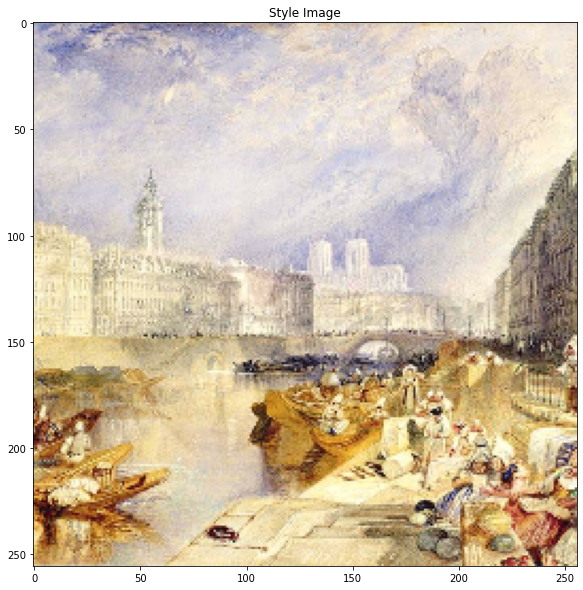

In [ ]:
plt.figure(figsize=(10, 10))
imshow(preprocessed_style_image, 'Style Image')

In [ ]:
content_blending_ratio = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
cap = cv2.VideoCapture("./local_capture.mp4")
dim = (384, 384)
writer = cv2.VideoWriter('capture.mp4', cv2.VideoWriter_fourcc(*'VIDX'),25, dim)

In [ ]:
while True:
    print(cnt)
    cnt+=1
    ret, frame = cap.read()
    if not ret:
        break

    content_image = load_content_img(frame)
    preprocessed_content_image = preprocess_image(content_image, 384)
    style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )
    style_bottleneck_blended = content_blending_ratio * style_bottleneck_content + (1 - content_blending_ratio) * style_bottleneck
    stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)
    
    
    
    stylized_image = stylized_image[0]
    print(stylized_image.shape, type(stylized_image))
    stylized_image = cv2.cvtColor(stylized_image, cv2.COLOR_BGR2RGB)
    imshow(stylized_image, 'Stylized Image')

    #convert to 0-255 range with uint8
    convertedImage = stylized_image*255
    convertedImage = np.asarray(convertedImage, dtype=np.uint8)
    writer.write(convertedImage)

    print(stylized_image.dtype)
    # store = stylized_image
    cv2.imshow('frame',stylized_image)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

In [ ]:
cap.release()
writer.release()
cv2.destroyAllWindows()